## 5.3.2 Gamma distribution and Laguerre Chaos

$$ f(k) = \frac{e^{-k} k^{\alpha}}{\Gamma(\alpha+1)} = gamma(\alpha+1, 1)$$

[Wiki - Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

When $\alpha=0$, then $f(k) = e^{-k}$; when $\alpha=1$, then $f(k)=e^{-k}k$
$$ \zeta \sim gamma(\alpha+1, 1)$$

[Gamma in Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)

$$ gamma.pdf(x, a) = \frac{\lambda^a  x^{a-1}  e^{-\lambda x} }{ \Gamma(a)}$$

where scale = 1.0 / lambda.

[Wiki - Laguerre Distribution](https://en.wikipedia.org/wiki/Laguerre_polynomials) Weight function is exp(1) pdf.

[Laguerre in Python](https://docs.scipy.org/doc/numpy-1.15.0/reference/routines.polynomials.laguerre.html)

**In Wiki and python package, they all treat Laguerre distribution with weight function to be exp(1) pdf. But here, the weight function is $g(\zeta)$**

**Laguerre Polynomial: ($\alpha = 0$)** (Python also uses this system, no sign switch)
$$
\begin{align*}
L_0 &= 1\\
L_1 &= -x + 1\\
L_2 &= \frac{1}{2}(x^2 - 4x + 2)\\
L_3 &= \frac{1}{6}(-x^3 + 9x^2 - 18x + 6)\\
L_4 &= \frac{1}{24}(x^4 - 16x^3 + 72x^2 - 96x + 24)\\
&\cdots
\end{align*}
$$
Corresponding Hypergeometric orthogonal polynomial
$$ L_n^{\alpha}(x) = \frac{(\alpha+1)_n}{n!}\  _1F_1(-n;\alpha+1;x)$$

In [8]:
import numpy as np
import numpy.polynomial.laguerre as La
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.special import gamma #gamma function
from scipy.stats import gamma as Gamma #gamma distribution
from math import factorial

%matplotlib notebook

`scipy.special.eval_genlaguerre`

In [2]:
def Lague_gen(params):
    '''
    The first 4 (degree from 0 to 4) Generalized Laguerre polynomial
    Follow definition on P642
    '''
    n = params[0]  #degree
    a = params[1]  #parameter alpha value
    
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: a+1-u
    elif n==2:
        return lambda u: (a+1)*(a+2)/2 - (a+2)*u + u**2/2
    elif n==3:
        return lambda u: (a+1)*(a+2)*(a+3)/6 - (a+2)*(a+3)*u/2 + (a+3)*u**2/2 - u**3/6 
    else: #this actually means n=4
        return lambda u: (a+1)*(a+2)*(a+3)*(a+4)/24 - (a+2)*(a+3)*(a+4)*u/6 + (a+3)*(a+4)*u**2/4 - (a+4)*u**3/6 + u**4/24

In [3]:
def Phi(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def inner2_la(params):
    n = params[0]
    a = params[1]  #store the value of alpha
    return gamma(n+a+1)/(factorial(n))
    
def product3_la(alpha,i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    if alpha==0:
        return lambda x: La.lagval(x, La.lagmul(La.lagmul(Phi(i),Phi(j)),Phi(l))) 
    else:
        return lambda x: Lague_gen((i,alpha))(x)*Lague_gen((j,alpha))(x)*Lague_gen((l,alpha))(x)
        
def inner3_la(alpha,P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    '''
    a indicates alpha in gamma distribution
    P indicates the number of expansion
    '''    
    if alpha==0:
        #a=0, this is Laguerre poly, we can directly use gauss-laguerre quadrature
        #Set up Gauss-Laguerre quadrature, weighting function is exp^{-x}
        m=(P+1)**2
        x, w=La.laggauss(m)        
        inner=sum([product3_la(alpha,i,j,l)(x[idx]) * w[idx] for idx in range(m)])
    else:
        #crude Monte Carlo
        nsample = 10000
        #rv = np.zeros(nsample)
        rv = Gamma.rvs(alpha+1, loc=0, scale=1, size=nsample)
        inner = np.mean(product3_la(alpha,i,j,l)(rv))*gamma(alpha+1)

    return inner

In [4]:
def ode_system_la(y, t, P, alpha):   
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_la(alpha,P,i,j,l)*ki_la[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_la((l,alpha))
    return dydt

<font color = red>This is $\alpha=0$
$\downarrow$

In [5]:
P = 4
alpha = 0
ki_la = [alpha+1, -1]+[0]*(P-1)    
sol_la = odeint(ode_system_la, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, alpha)) 

In [6]:
def y_determ_la(x):
    return np.e**(-x)

<IPython.core.display.Javascript object>


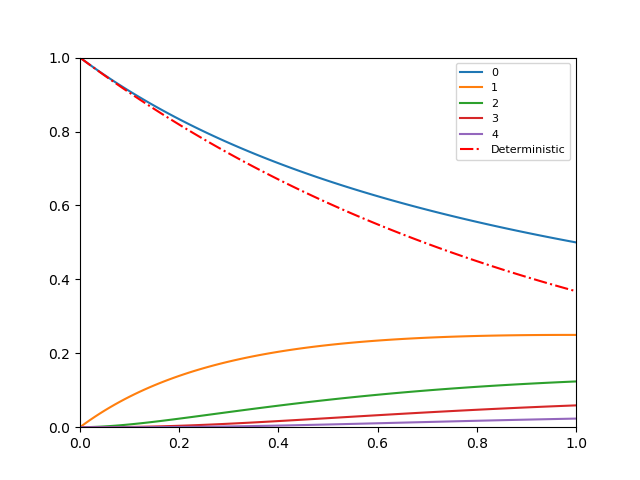

In [9]:
plt.figure()
plt.ylim([0,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_la[:,i],label=i)

plt.plot(x, y_determ_la(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

### Error plot
$$
\bar{y}_{exact}(t) = \frac{\hat{y_0}}{(1+t)^{\alpha+1}} \ \ \ \ \ \ \ \ \bar{y}(t) = y_0
$$
So 
$$
\epsilon_{mean}(t) = \left| \frac{\bar{y}(t) - \bar{y}_{exact}(t)}{\bar{y}_{exact}(t)}\right|
$$

$$
\sigma_{exact}(t) = \frac{\hat{y_0}^2}{(2t+1)^{\alpha+1}} - \frac{\hat{y_0}^2}{(t+1)^{2\alpha+2}}  \ \ \ \ \ \ \ \ \sigma(t) = a_1y_1^2 +a_2y_2^2+a_3y_3^2+a_4y_4^2
$$
The coefficients $(a_1, a_2, a_3, a_4)$ in $\sigma(t)$ can be obtained by code below.

So
$$
\epsilon_{variance}(t) = \left| \frac{\sigma(t) - \sigma_{exact}(t)}{\sigma_{exact}(t)} \right|= \ldots
$$

`expect(func, args=(a,), loc=0, scale=1, lb=None, ub=None, conditional=False, **kwds)`

<font color = red>This is $\alpha=0$
$\downarrow$

In [10]:
alpha = 0 
allcoeff_532_0 = np.zeros((5,4))  
        #532 indicates example 5.3.2, 0 indicates \alpha=0
        #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_532_0[0,:]=np.ones(4) + alpha
allcoeff_532_0[1,:]=-1*np.ones(4)
y_532_0 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

alpha = 0
for i in range(4):
    P=i+1
    ki_la = allcoeff_532_0[:,i]
    y_mid=odeint(ode_system_la, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, alpha))[1,:]
    y_532_0[:,i] = y_mid.tolist()+[0]*(4-P)

In [11]:
print(y_532_0)

[[0.4799642  0.49730311 0.49965577 0.49995737]
 [0.18517912 0.2376679  0.24796613 0.24969117]
 [0.         0.09288212 0.11833716 0.1237815 ]
 [0.         0.         0.04652817 0.05903265]
 [0.         0.         0.         0.02329304]]


In [12]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(Gamma.expect(Lague_gen((i,0)), args=(1,), loc=0, lb=None, ub=None, conditional=False))

1.0000000000000002
1.6393136847980827e-16
4.3300324263639833e-17
-7.587177769144576e-17
-2.2998638583848763e-16
-2.2998638583848763e-16
-2.2998638583848763e-16
-2.2998638583848763e-16
-2.2998638583848763e-16


In [13]:
def g(params):
    n = params
    return lambda u: (Lague_gen((n,0))(u))**2

for i in range(1,5):
    print(Gamma.expect(g(i), args=(1,), loc=0, scale=1, lb=None, ub=None, conditional=False))

1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002


In [15]:
############# alpha = 0  ################ 
error_mean_532_0=np.abs(2*y_532_0[0,:]-1)


sigma2_532_0=np.zeros(4)
for i in range(4):
    sigma2_532_0[i]=y_532_0[1,i]**2+y_532_0[2,i]**2+y_532_0[3,i]**2+y_532_0[4,i]**2
    
sigma2_exact_532_0 = 1/12
error_var_532_0=np.abs((sigma2_532_0-sigma2_exact_532_0)/sigma2_exact_532_0)

<font color = red>This is $\alpha=1$
$\downarrow$

In [16]:
alpha = 1
allcoeff_532_1 = np.zeros((5,4))  
allcoeff_532_1[0,:]=np.ones(4) + alpha
allcoeff_532_1[1,:]=-1*np.ones(4)
y_532_1 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

for i in range(4):
    P=i+1
    ki_la = allcoeff_532_1[:,i]
    y_mid=odeint(ode_system_la, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, alpha))[1,:]
    y_532_1[:,i] = y_mid.tolist()+[0]*(4-P)

/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [20]:
print(y_532_1)

[[ 9.66190012e-01  9.75068782e-01  9.53813531e-01  9.98929999e-01]
 [ 1.66902796e-02  1.24907477e-02  2.30202300e-02  5.52538751e-04]
 [ 0.00000000e+00  1.57798433e-04  4.34821700e-04  3.82522093e-05]
 [ 0.00000000e+00  0.00000000e+00  2.37827688e-04 -5.86060142e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.54681813e-06]]


In [21]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(Gamma.expect(Lague_gen((i,1)), args=(2,), loc=0, lb=None, ub=None, conditional=False))

0.9999999999999997
-7.714098457234364e-17
-3.393552799879629e-17
-1.9081958235744878e-17
1.0182826803983858e-15
1.0182826803983858e-15
1.0182826803983858e-15
1.0182826803983858e-15
1.0182826803983858e-15


In [22]:
def g(params):
    n = params
    return lambda u: (Lague_gen((n,1))(u))**2

for i in range(1,5):
    print(Gamma.expect(g(i), args=(2,), loc=0, scale=1, lb=None, ub=None, conditional=False))

2.0000000000000004
3.0
4.0
5.000000000000002


In [23]:
############# alpha = 1  ################ 
error_mean_532_1=np.abs(4*y_532_1[0,:]-1)


sigma2_532_1=np.zeros(4)
for i in range(4):
    sigma2_532_1[i]=2*y_532_1[1,i]**2+3*y_532_1[2,i]**2+4*y_532_1[3,i]**2+5*y_532_1[4,i]**2
    
sigma2_exact_532_1 = 7/144
error_var_532_1=np.abs((sigma2_532_1-sigma2_exact_532_1)/sigma2_exact_532_1)


### <font color = red> The error plots when $\alpha=0$ are correct, I am using Laguerre package in python since $\alpha=0$.
    
### <font color = red> But when $\alpha=1$, the error plots are so strange, I am using the Laguerre functions I defined by myself

<IPython.core.display.Javascript object>


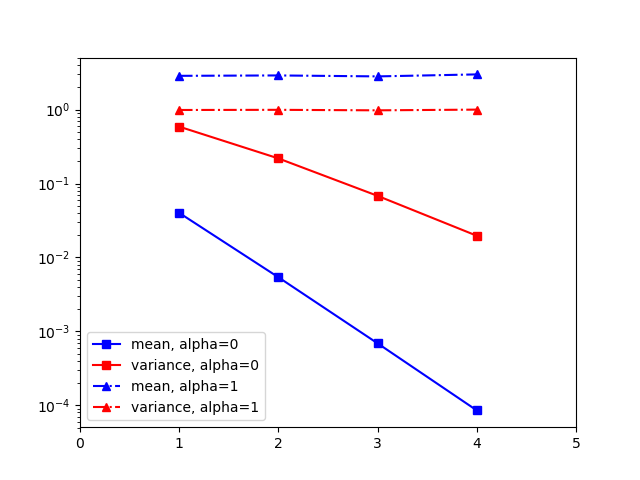

In [24]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_532_0,'-bs',label= 'mean, alpha=0')
plt.semilogy([1,2,3,4],error_var_532_0,'-rs',label='variance, alpha=0')  
plt.semilogy([1,2,3,4],error_mean_532_1,'-.b^',label='mean, alpha=1')
plt.semilogy([1,2,3,4],error_var_532_1,'-.r^',label='variance, alpha=1')     
plt.legend()